# Sanity Check of the Borrowing Dataset

This notebook is used to explore the provided borrowing dataset, identify potential issues, and build an initial understanding of the availabe data.
The goal is to analyse the data quality and highlight problems such as missing entries, inconsistent values, or unusual patterns.

The dataset originates form a libary management system and contains information about individual borrowing transactions, such as checkout time, return time, loan durration, user category, media type, and bibliographic details.

The data is stored in a seperate CSV file for each year. Data is availabe from the beginning of 2019 until November 24, 2025.

The amount of data differs over the years:

,year,entries
0,2019,393533
1,2020,336369
2,2021,253053
3,2022,306577
4,2023,378329
5,2024,381935
6,2025,357814


Total number of borrowing entries from 2019 to 2025: 2407610


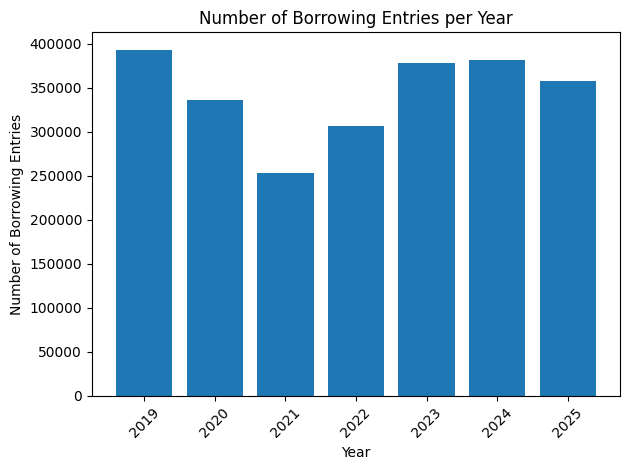

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

data_dir = Path('../data/raw/borrowings')

files = sorted(data_dir.glob('borrowings_*.csv'))

yearly_counts = {}
years = []

for file in files:
    df = pd.read_csv(file, sep=';', quotechar='"', encoding='utf-8')
    year = file.stem.split('_')[-1]
    yearly_counts[year] = len(df)
    years.append(year)

count_df = pd.DataFrame(
    {'year': list(yearly_counts.keys()), 'entries': list(yearly_counts.values())}
).sort_values(by='year')

display(count_df)

tototal_entries = count_df['entries'].sum()
print(f'Total number of borrowing entries from {years[0]} to {years[-1]}: {tototal_entries}')

# plot
plt.figure()
plt.bar(count_df['year'], count_df['entries'])
plt.xlabel('Year')
plt.ylabel('Number of Borrowing Entries')
plt.title('Number of Borrowing Entries per Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We want to look at the the data for the entire period, so it is merged into one file: "../data/processed/borrowings_2019_2025.csv"

In [6]:
all_dfs = []

for file in files:
    df_year = pd.read_csv(file, sep=';', quotechar='"', encoding='utf-8')
    all_dfs.append(df_year)

df_all = pd.concat(all_dfs, ignore_index=True)

print("Merged shape: ", df_all.shape)

output_file = Path(f'../data/processed/borrowings_{years[0]}_{years[-1]}.csv')
output_file.parent.mkdir(parents=True, exist_ok=True)
df_all.to_csv(output_file, index=False, sep=';', quotechar='"', encoding='utf-8')
print(f'Merged data saved to {output_file}')

Merged shape:  (2407610, 16)
Merged data saved to ../data/processed/borrowings_2019_2025.csv


## Dataset Overview

Each row in the dataset represents a single borrowing transaction.

- **issue_id**: Unique identifier of the borrowing transaction *(int)*
- **Ausleihdatum/Uhrzeit**: Date and time when the item was borrowed *(datetime)*
- **Rückgabedatum/Uhrzeit**: Date and time when the item was returned *(datetime)*
- **Leihdauer**: Duration of the loan in days *(int)*
- **Anzahl_Verlängerungen**: Number of times the loan was extended *(int)*
- **Verspätet**: Indicates whether the return was late *(bool)*
- **Tage_zu_spät**: Number of days the return was overdue *(int)*
- **Sammlungszeichen/CCODE**: Internal collection or classification code *(string / category)*
- **Medientyp**: Type of media (e.g. book, DVD) *(string / category)*
- **Barcode**: Unique physical item identifier *(string)*
- **Titel**: Title of the borrowed item *(string)*
- **Autor**: Author of the item *(string)*
- **ISBN**: International Standard Book Number *(string)*
- **Interessenkreis**: Subject or interest category *(string / category)*
- **Benutzerkategorie**: Category of the borrowing user *(string / category)*
- **Benutzer-Systemnummer**: Unique system ID of the user *(string / int)*

In [27]:
df.columns.tolist()

['issue_id',
 'Ausleihdatum/Uhrzeit',
 'Rückgabedatum/Uhrzeit',
 'Leihdauer',
 'Anzahl_Verlängerungen',
 'Verspätet',
 'Tage_zu_spät',
 'Sammlungszeichen/CCODE',
 'Medientyp',
 'Barcode',
 'Titel',
 'Autor',
 'ISBN',
 'Interessenkreis',
 'Benutzerkategorie',
 'Benutzer-Systemnummer']

## Missing Values and Completness

In this step, we examine the the completeness of the dataset by identifying missing or empty values in each column.
Missing values can indicate issues such as incompletete records or irregular entries in the libary system.

Understanding which values are affected helps assess overall data quality and guides later data cleaning steps.

We inspect both:
- standard missing values ('NaN')
- empty strings (e.g., incomplete text fields like title, author, ISBN)

This provides a clear picture of how reliable each column is across all years.

In [7]:
missing_percent = (df_all.isna().mean().sort_values(ascending=False) * 100)

print("=== Percentage of missing values per column over the complete Data: ===")
display(missing_percent)

# Jahr der Ausleihe oder Rückgabe extrahieren
issue_year = pd.to_datetime(df_all['Ausleihdatum/Uhrzeit'], errors='coerce').dt.year
df_all['year'] = issue_year

# Gesamt-Missing-Rate pro Jahr (über alle Spalten)
# Anteil der Zellen, die NaN sind, pro Jahr
missing_overall_by_year = (
    df_all
    .set_index('year')
    .isna()
    .mean(axis=1)
    .groupby(level=0)
    .mean()
    .rename('missing_rate')
    .to_frame()
)

print("=== Overall missing rate per year (across all columns) ===")
display(missing_overall_by_year.style.format({'missing_rate': '{:.2%}'}))

# Missing-Rate pro Spalte und Jahr
missing_by_year_and_col = (
    df_all
    .groupby('year')
    .agg(lambda x: x.isna().mean())
    .sort_index()
)

# Nur ausgewählte Spalten anzeigen
core_cols = [
    'Ausleihdatum/Uhrzeit',
    'Rückgabedatum/Uhrzeit',
    'Leihdauer',
    'Anzahl_Verlängerungen',
    'Verspätet',
    'Tage_zu_spät',
    'Sammlungszeichen/CCODE',
    'Medientyp',
    'Barcode',
    'Titel',
    'Autor',
    'ISBN',
    'Interessenkreis',
    'Benutzerkategorie',
    'Benutzer-Systemnummer'
]

print("\n=== Missing rate of selected columns per year ===")
display(missing_by_year_and_col[core_cols].style.format('{:.2%}'))


=== Percentage of missing values per column over the complete Data: ===


Autor                     39.050843
Interessenkreis           37.437583
ISBN                      34.025154
Sammlungszeichen/CCODE    17.393722
Titel                     17.330880
Medientyp                 17.330714
Barcode                   17.330506
Benutzerkategorie          6.782909
Benutzer-Systemnummer      6.782909
Rückgabedatum/Uhrzeit      2.026325
Leihdauer                  2.026325
Tage_zu_spät               2.026325
issue_id                   0.000000
Ausleihdatum/Uhrzeit       0.000000
Anzahl_Verlängerungen      0.000000
Verspätet                  0.000000
dtype: float64

=== Overall missing rate per year (across all columns) ===


,missing_rate
year,
2019,21.53%
2020,18.01%
2021,14.15%
2022,11.54%
2023,9.07%
2024,6.39%
2025,7.01%



=== Missing rate of selected columns per year ===


,Ausleihdatum/Uhrzeit,Rückgabedatum/Uhrzeit,Leihdauer,Anzahl_Verlängerungen,Verspätet,Tage_zu_spät,Sammlungszeichen/CCODE,Medientyp,Barcode,Titel,Autor,ISBN,Interessenkreis,Benutzerkategorie,Benutzer-Systemnummer
year,,,,,,,,,,,,,,,
2019,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,35.20%,35.18%,35.18%,35.18%,59.14%,51.83%,52.37%,20.21%,20.21%
2020,0.00%,0.01%,0.01%,0.00%,0.00%,0.01%,29.10%,29.06%,29.06%,29.06%,51.14%,45.92%,46.13%,14.28%,14.28%
2021,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,22.79%,22.73%,22.73%,22.73%,43.24%,37.61%,39.55%,7.51%,7.51%
2022,0.00%,0.01%,0.01%,0.00%,0.00%,0.01%,17.40%,17.32%,17.32%,17.32%,38.70%,33.18%,36.34%,3.50%,3.50%
2023,0.00%,0.02%,0.02%,0.00%,0.00%,0.02%,11.99%,11.91%,11.91%,11.91%,33.39%,28.89%,33.13%,0.97%,0.97%
2024,0.00%,0.02%,0.02%,0.00%,0.00%,0.02%,5.64%,5.57%,5.57%,5.57%,26.90%,22.93%,29.04%,0.48%,0.48%
2025,0.00%,13.57%,13.57%,0.00%,0.00%,13.57%,1.24%,1.16%,1.15%,1.15%,21.89%,18.72%,25.80%,0.15%,0.15%


## Checking Loan and Return Dates

Here we check if the loan and return dates make sense and if the loan period is correctly recorded in the CSV file.
We calculate the loan duration by subtracting the loan date from the return date and using standard rounding to get whole days.
We show how many loan periods differ from the CSV file and by how many days. We also check if there are negative time periods or identical loan and return timestamps.

In [29]:
# Konvertierung der Datums-Spalten
df_all['Ausleihdatum/Uhrzeit'] = pd.to_datetime(df_all['Ausleihdatum/Uhrzeit'], errors='coerce')
df_all['Rückgabedatum/Uhrzeit'] = pd.to_datetime(df_all['Rückgabedatum/Uhrzeit'], errors='coerce')

total_rows = len(df_all)

# Offene Ausleihen
open_loans_mask = df_all['Rückgabedatum/Uhrzeit'].isna() & df_all['Ausleihdatum/Uhrzeit'].notna()
open_loans_count = open_loans_mask.sum()

# Zurückgegebene Ausleihen
complete_mask = df_all['Ausleihdatum/Uhrzeit'].notna() & df_all['Rückgabedatum/Uhrzeit'].notna()

# Exakte Zeitberechnung mit Auf und Abrunden je nach Zeitdifferenz
df_all.loc[complete_mask, 'Leihdauer_neu'] = np.round(
    (df_all.loc[complete_mask, 'Rückgabedatum/Uhrzeit'] - df_all.loc[complete_mask, 'Ausleihdatum/Uhrzeit']).dt.total_seconds() / 86400
).astype(int)

# Ändere orginal Leihdauerstrings zu numerischen Werten und speicher in neuer Spalte
df_all['Leihdauer_num'] = pd.to_numeric(df_all.get('Leihdauer'), errors='coerce')

# Vergleichsmaske: nur vollständige Datensätze mit numerischer Leihdauer
compare_mask = complete_mask & df_all['Leihdauer_num'].notna()

# Differenz in Tagen zwischen berechneter und Leihdauer aus CSV
df_all.loc[compare_mask, 'Diff_in_Tagen'] = df_all.loc[compare_mask, 'Leihdauer_neu'] - df_all.loc[compare_mask, 'Leihdauer_num']

# Zählen der Fälle mit positiver, negativer und null Differenz
pos = (df_all['Diff_in_Tagen'] > 0).sum()
neg = (df_all['Diff_in_Tagen'] < 0).sum()
zero = (df_all['Diff_in_Tagen'] == 0).sum()

# Ausgabe der Ergebnisse
print("=== Loan Duration ===")
print(f"Total rows: {total_rows}")
print(f"Returned loans: {complete_mask.sum()} ({complete_mask.sum()/total_rows:.2%})")
print(f"Open loans: {open_loans_count} ({open_loans_count/total_rows:.2%})")

print("\n=== Comparison: loan duration CSV vs. calculated ===")
print(f"Comparable cases: {compare_mask.sum()}")
print(f" - Calculated longer: {pos} ({(pos/max(compare_mask.sum(),1)):.2%})")
print(f" - Both equal: {zero} ({(zero/max(compare_mask.sum(),1)):.2%})")
print(f" - Calculated shorter: {neg} ({(neg/max(compare_mask.sum(),1)):.2%})")

# Kompakte, lesbare Tabelle der Differenzen
Diff_in_Tagen_counts = df_all.loc[compare_mask, 'Diff_in_Tagen'].value_counts().sort_index()

Diff_in_Tagen_summary = (
    Diff_in_Tagen_counts.rename('Anzahl')
    .to_frame()
    .assign(Anteil=lambda x: x['Anzahl'] / max(compare_mask.sum(), 1))
    .reset_index()
    .rename(columns={'index': 'Differenz (berechnet - Original)'})
)

print("\n=== Distribution of difference ===")
display(Diff_in_Tagen_summary.head(15).style.format({'Anteil': '{:.2%}'}))

# Roh-Differenz für Zusatzanalysen
delta_raw = df_all.loc[complete_mask, 'Rückgabedatum/Uhrzeit'] - df_all.loc[complete_mask, 'Ausleihdatum/Uhrzeit']
zero_day = (delta_raw.dt.days == 0).sum()
zero_exact_ts = (delta_raw.dt.total_seconds() == 0).sum()

print("\n=== Edge Cases ===")
print(f"Same day borrow and returns (but different times): {zero_day}")
print(f"Exactly identical timestamp for borrowing and returning: {zero_exact_ts}")


# Prüfung auf negative Zeitdifferenzen (Datenfehler) im Datensatz
negative_mask = delta_raw.dt.total_seconds() < 0
negative_count = negative_mask.sum()

print("\n=== Data Quality Check ===")
print(f"Negative time differences (data errors): {negative_count}")

# Gibt Beispiele für negative Zeitdifferenzen aus, falls vorhanden
if negative_count > 0:
    neg_examples = df_all.loc[complete_mask].loc[negative_mask, [
        'Ausleihdatum/Uhrzeit','Rückgabedatum/Uhrzeit','Leihdauer_num','Leihdauer_neu','Diff_in_Tagen'
    ]].head(15)
    print("\nExamples of negative cases (sample):")
    display(neg_examples)

=== Loan Duration ===
Total rows: 2407610
Returned loans: 2358824 (97.97%)
Open loans: 48786 (2.03%)

=== Comparison: loan duration CSV vs. calculated ===
Comparable cases: 2358824
 - Calculated longer: 195 (0.01%)
 - Both equal: 2357887 (99.96%)
 - Calculated shorter: 742 (0.03%)

=== Distribution of difference ===


,Diff_in_Tagen,Anzahl,Anteil
0,-1.000000,742,0.03%
1,0.000000,2357887,99.96%
2,1.000000,195,0.01%



=== Edge Cases ===
Same day borrow and returns (but different times): 45638
Exactly identical timestamp for borrowing and returning: 0

=== Data Quality Check ===
Negative time differences (data errors): 0


In [30]:
print("\n=== Duplicate Rows Check ===")

# Komplett identische Zeilen
duplicate_count = df_all.duplicated().sum()
print(f"Number of complete duplicate rows: {duplicate_count}")

# dentische Ausleihe- und Rückgabezeiten
exact_timestamp_duplicates = df_all.duplicated(subset=['Ausleihdatum/Uhrzeit', 'Rückgabedatum/Uhrzeit'])
exact_timestamp_count = exact_timestamp_duplicates.sum()
print(f"Rows with identical borrow and return timestamps: {exact_timestamp_count}")

#if exact_timestamp_count > 0:
#    print("\nExamples of exact timestamp duplicates:")
#    display(df_all.loc[exact_timestamp_duplicates, [
#        'Ausleihdatum/Uhrzeit', 'Rückgabedatum/Uhrzeit', 'Leihdauer', 'Benutzer-Systemnummer'
#    ]].head(5))

# Identische Zeitstempel + gleicher Benutzer
exact_user_timestamp_duplicates = df_all.duplicated(
    subset=['Ausleihdatum/Uhrzeit', 'Rückgabedatum/Uhrzeit', 'Benutzer-Systemnummer']
)
exact_user_timestamp_count = exact_user_timestamp_duplicates.sum()
print(f"\nRows with identical borrow and return timestamps and same user: {exact_user_timestamp_count}")

if exact_user_timestamp_count > 0:
    print("\nExamples (same user, same timestamps):")
    display(df_all.loc[exact_user_timestamp_duplicates, [
        'Ausleihdatum/Uhrzeit', 'Rückgabedatum/Uhrzeit', 'Benutzer-Systemnummer'
    ]].head(5))

# Identische Zeitstempel aber verschiedene Benutzer
timestamp_user_stats = df_all.groupby(['Ausleihdatum/Uhrzeit', 'Rückgabedatum/Uhrzeit']).agg({
    'Benutzer-Systemnummer': 'nunique'
}).rename(columns={'Benutzer-Systemnummer': 'unique_users'})

multi_user_timestamps = (timestamp_user_stats['unique_users'] > 1).sum()
print(f"\nSame borrow and return timestamps with different users_ID: {multi_user_timestamps}")

# Gleiche Ausleihe-Zeit (ohne Rückgabe) aber verschiedene Benutzer
issue_time_stats = df_all.groupby('Ausleihdatum/Uhrzeit').agg({
    'Benutzer-Systemnummer': 'nunique'
}).rename(columns={
    'Benutzer-Systemnummer': 'unique_users'
})

multi_user_issue_times = issue_time_stats[issue_time_stats['unique_users'] > 1]
print(f"\nSame borrow times with different users_ID: {len(multi_user_issue_times)}")

if len(multi_user_issue_times) > 0:
    print("\nExamples of same borrow time with different users:")
    example_times = multi_user_issue_times.head(3).index
    examples = df_all[df_all['Ausleihdatum/Uhrzeit'].isin(example_times)].sort_values(
        ['Ausleihdatum/Uhrzeit', 'Benutzer-Systemnummer']
    )[['Ausleihdatum/Uhrzeit', 'Rückgabedatum/Uhrzeit', 'Benutzer-Systemnummer', 'Barcode']].head(5)
    display(examples)

# Gemeinsame Ausleihe-Zeit + gleicher Benutzer aber mehrere Medien
same_user_same_time = df_all.groupby(['Ausleihdatum/Uhrzeit', 'Benutzer-Systemnummer']).size()
multi_item_checkouts = (same_user_same_time > 1).sum()
print(f"Cases where one user checked out multiple items at exact same time: {multi_item_checkouts}")

if multi_item_checkouts > 0:
    max_simultaneous = same_user_same_time.max()
    print(f"Maximum items checked out simultaneously by one user: {max_simultaneous}")


=== Duplicate Rows Check ===
Number of complete duplicate rows: 0
Rows with identical borrow and return timestamps: 12016

Rows with identical borrow and return timestamps and same user: 11573

Examples (same user, same timestamps):


,Ausleihdatum/Uhrzeit,Rückgabedatum/Uhrzeit,Benutzer-Systemnummer
41190,2019-02-28 15:51:14,2019-04-18 12:07:41,10053.0
48098,2019-03-06 11:52:29,2019-06-13 16:30:16,27280.0
63089,2019-03-16 13:34:58,2019-05-07 17:12:02,NaN
89513,2019-04-10 10:44:42,2019-05-22 16:33:04,28306.0
89514,2019-04-10 10:44:42,2019-05-22 16:33:04,28306.0



Same borrow and return timestamps with different users_ID: 1

Same borrow times with different users_ID: 37790

Examples of same borrow time with different users:


,Ausleihdatum/Uhrzeit,Rückgabedatum/Uhrzeit,Benutzer-Systemnummer,Barcode
0,2019-01-02,2019-01-24 13:23:23,26.0,NaN
1,2019-01-02,2019-01-30 13:40:14,50.0,NaN
2,2019-01-02,2019-03-06 07:09:36,50.0,18143906
3,2019-01-02,2019-03-06 07:09:38,50.0,18184110
4,2019-01-02,2019-03-06 07:09:31,50.0,17202121


Cases where one user checked out multiple items at exact same time: 277635
Maximum items checked out simultaneously by one user: 7
